# Predicting Pet Insurance Claims - Model Tuning and Predictions
## 1 Introduction
### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future.

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in USD) a given policy holder will claim for during the second year of their policy.

### 1.3 Notebook Goals
* TBD

# Add Goals

## 2 Setup
### 2.1 Imports

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import __version__ as sklearn_version

# import datetime
# import os
# import pickle
# from library.sb_utils import save_file

### 2.2 Data and Initial Modeling Results
We ended preprocessing and initial modeling with our training and test sets and some initial results. In order to continue on enhancing our model, we need to load in our training and test data as a first step. 

#### 2.2.1 Data Load
Let's take a look at the shape of our training and test sets and get a preview of our test data.

In [2]:
# Read in the training and test sets
X_train = pd.read_csv('../data/X_train.csv', index_col=0)
y_train = np.genfromtxt('../data/y_train.csv', delimiter=',')
X_test = pd.read_csv('../data/X_test.csv', index_col=0)
y_test = np.genfromtxt('../data/y_test.csv', delimiter=',')

# Preview the shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 12)
(10000, 12)
(40000,)
(10000,)


In [3]:
# Preview the training data
X_train.head(8).T

0           1           2           3  \
Species                      Dog         Dog         Dog         Dog   
AgeYr1                         3           0           0           1   
YoungAge                       0           0           0           0   
AmtClaimsYr1               76.25         0.0     6010.88      303.15   
AvgClaimsYr1               76.25         0.0  546.443636     151.575   
NumClaimsYr1                   1           0          11           2   
BreedAvgTotalClaims   663.502526  540.515378   705.72864   705.72864   
BreedAvgNumClaims       1.491045    1.627294    1.766242    1.766242   
BreedAvgClaimAmt      196.601991  159.645266  198.844913  198.844913   
AgeYr1AvgTotalClaims  722.652663  902.942389  902.942389  699.071121   
AgeYr1AvgNumClaims      1.275474    2.002704    2.002704    1.359896   
AgeYr1AvgClaimAmt     218.098714  234.275301  234.275301  212.218786   

                               4           5           6            7  
Species                      Dog         Dog         Cat          Dog  
AgeYr1                         2           0           6            6  
YoungAge                       0           0           0            0  
AmtClaimsYr1                 0.0       701.6      431.57          0.0  
AvgClaimsYr1                 0.0       701.6     215.785          0.0  
NumClaimsYr1                   0           1           2            0  
BreedAvgTotalClaims   663.502526  925.434405  395.718466  1509.175333  
BreedAvgNumClaims       1.491045    1.875611    0.871485     2.552941  
BreedAvgClaimAmt      196.601991  240.294459  137.970879   315.759532  
AgeYr1AvgTotalClaims  619.496248  902.942389  449.891932   904.086963  
AgeYr1AvgNumClaims      1.243786    2.002704    0.942029      1.47284  
AgeYr1AvgClaimAmt     198.114908  234.275301  124.637412   330.747276

#### 2.2.2 Initial Modeling Results
In the previous notebook, we completed some initial modeling including the following:
* Established a baseline using `DummyRegressor()` with predictions equivalent to the mean value of the target 
* Created a simple liner model using `LinearRegressor()` and default settings
* Enhanced our simple linear model by incorporating feature selection and making predictions using the best 'k' features

Using the linear model with feature selection, we managed to improve upon the baseline model by **~9%**, or over **\$90** per customer. Given the size of the total customer base (~65-75 million pets), this represents a significant total value that could be realized by factoring model predictions into policy premium and deductible amounts.

In this notebook, we'll continue tuning our model and evaluating additional modeling approaches to see if we can improve upon the initial result. Following this evaluation, we will select our final model and make predictions on our test set to generate final results. Our best model so far is using a **simple linear regression model with feature selection**. This resulted in a mean absolute error of **~\\$930**. So there could be a lot of room for improvement if we can find a model that better suits our data.

#### 2.2.3 Data Preprocessing
In our previous notebook, we also created a simple preprocessor to handle our remaining category data in the Species column. We'll recreate that here for use in our model pipelines throughout.

In [5]:
# Create a preprocessor to encode the remaining categorical column
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['Species']), remainder='passthrough')

## 3 Lasso Regression
For our first modeling technique, we'll utilize **Lasso Regression**. Lasso can be useful in cases where only a few of the features are actually influencing the predictions. As observed in the previous notebook, our situation is similar here. Although we saw 9 features selected as a result of using the 'best k' features, only 2 or 3 appeared to have significant coefficient values with the remainder very close to zero.

For Lasso, we'll start off by utilizing a basic version of the algorithm with no tuning and then we'll utilize grid search to see if we can tune the results further. 

### 3.1 Simple Lasso Regression Model

In [6]:
# Make pipeline, cross validate and get results
pipe = make_pipeline(preprocessor, Lasso())
cv_results = cross_validate(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
score_mean = -1 * round(np.mean(cv_results['test_score']), 2)
print("mean test score (mae): " + str(score_mean))

mean test score (mae): 930.28


So utilizing Lasso regression with default settings, we've managed to improve our MAE by about 0.07. Overall, not great. Let's see what we can do by applying grid search and searching over a range of parameter values.

### 3.2 Lasso Regression with GridSearchCV

In [9]:
# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),('regressor', Lasso())])

# Establish the parameter grid
param_grid = {'regressor__alpha': [0.1, 1, 5, 10], 'regressor__fit_intercept': [True, False],
              'regressor__normalize': [True, False]}

# Instantiate the grid search and fit the model
Lasso_GS = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
Lasso_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species'])])),
                                       ('regressor', Lasso())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.1, 1, 5, 10],
                         'regressor__fit_intercept': [True, False],
                         'regressor__normalize': [True, False]},
             scoring='neg_mean_absolute_error')

In [10]:
# Print best test score
best_score = -1 * round(np.max(Lasso_GS.cv_results_['mean_test_score']), 2)
print("best score (mae): " + str(best_score))

best score (mae): 930.18


In [11]:
Lasso_GS.best_params_

{'regressor__alpha': 5,
 'regressor__fit_intercept': True,
 'regressor__normalize': False}

Again, we see a very modest improvement in the Lasso regression results by adding parameter tuning. We could continue tweaking our parameter grid, but given the very small amount of improvement so far, it seems unlikely that we will see a substantial improvement by continuing to fine tune the model.

Rather than focusing more time on Lasso, let's move on to try a few additional models, starting with **Gradient Boosting**.


## 4 Gradient Boosting
Up to this point, we seem to be hitting a wall when it comes to model performance gains with our **MAE values plateauing at ~930**. 

One reason for this could very well be that our data simply doesn't fit well into a linear model. As observed throughout this project, none of our features are regularly distributed and our target (i.e., Insurance Claims Amount) is mostly random in nature and as a result, difficult to predict with precision.

Given this fact, it stands to reason that we need a model such as Gradient Boosting that can perform well with unbalanced data.

### 4.1 Simple Gradient Boosting Model

In [20]:
# Make pipeline, cross-validate, and get results
pipe = make_pipeline(preprocessor, GradientBoostingRegressor())
cv_results = cross_validate(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
score_mean = -1 * round(np.mean(cv_results['test_score']), 2)
print("mean test score (mae): " + str(score_mean))

mean test score (mae): 932.56


Using a simple Gradient Boosting model, we see our predictive accuracy actually got worse. That's not too surprising considering we made no effort to tune the model, but it might be an early indication that we won't see much improvement over and above our current best score of ~930. 

As a next step, let's start by tuning 'n_estimators' (the number of boosting stages) and 'learning_rate' (which shrinks the contribution of each tree. There is typically a tradeoff between these two parameters and so finding the right balance will help provide us with a good foundation to continue the tuning process.

For this tuning step, we'll implement a grid search using a range of values for each of the two parameters mentioned above, and we'll stay with the default values for all other parameters for now. Afterwards, we can see which pair of values gave us the best performance and also plot the overall results.



In [253]:
# Instantiate the regressor model
regressor = GradientBoostingRegressor(random_state=23)

# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('regressor', regressor)
                ])

# Establish the parameter grid
param_grid = { 'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
               'regressor__n_estimators': range(10, 110, 10),
              }

# Instantiate the grid search and fit the model
GB_GS = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
GB_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=23))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1,
                                                      0.2],
                         'regressor__n_estimators': range(10, 110, 10)},
             scoring='neg_mean_absolute_error')

In [254]:
# Print best test score
best_score = -1 * round(np.max(GB_GS.cv_results_['mean_test_score']), 2)
print("Best Score (MAE): " + str(best_score) + "\n")

# Print best params from grid search
print("Best Params:"), GB_GS.best_params_

Best Score (MAE): 931.92

Best Params:


(None, {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 80})

With some basic tuning, we managed to see a modest improvement, but we are still hovering around the ~930 range. Before moving on with more advanced tuning, let's plot the results to get a better feel for how these two parameters are affecting the scores. We can create a function for this that will come in handy as we continue tuning our model.

In [255]:
# Create a function for plotting the 
def plot_grid_search_results(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    
    #TODO - Add docstring
    
    # Get mean test score for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot grid search scores
    _, ax = plt.subplots(1,1, figsize=(12, 6))

    # Param_1 is the X-axis, Param 2 is represented as a different color line on the plot
    for idx, val in enumerate(grid_param_2):
        plt.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    plt.suptitle("Grid Search Scores", y=0.95, fontsize=14)
    plt.xlabel(name_param_1, fontsize=12) 
    plt.ylabel('CV Average Score', fontsize=12) 
    plt.legend(loc="best", fontsize=12, bbox_to_anchor=(1, 1.02))

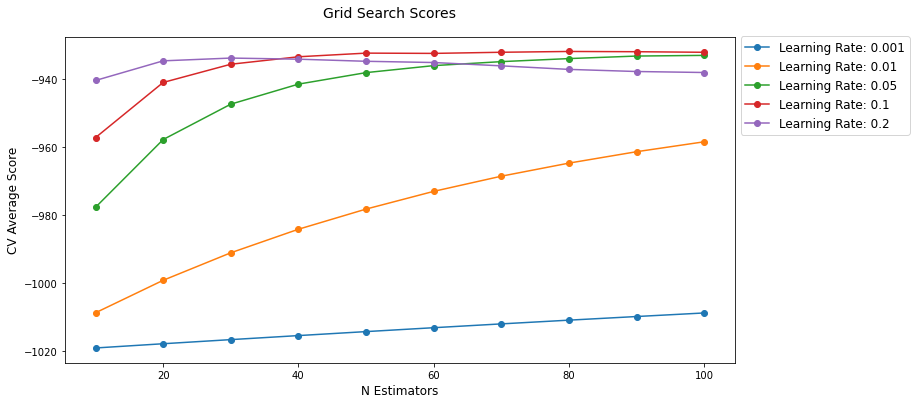

In [256]:
# Plot the results
plot_grid_search_results(GB_GS.cv_results_, 
                         GB_GS.param_grid['regressor__n_estimators'],
                         GB_GS.param_grid['regressor__learning_rate'], 
                         'N Estimators', 'Learning Rate')

We can see above, that our best set of parameters for n_estimators and learning_rate are 80 and 0.1, respectively. These are pretty close the the model defaults (i.e., 100, 0.1), so it isn't surprising that we didn't see much of an improvement. Next, let's focus on tuning the 'subsample' and 'loss' parameters in a similar fashion.

Subsample, is the fraction of samples used in fitting the base learners. By reducing this to less than 1, we may be able to reduce the variance in our model and increase bias. We'll try a range of values for subsample from 0.2-0.9.

The default for loss is 'squared_error'. For this round of testing, we'll also include 'huber', which is a combination of 'squared_error' and 'absolute_error'.

In [250]:
# Instantiate the regressor model
regressor = GradientBoostingRegressor(n_estimators=80, random_state=23)

# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('regressor', regressor)
                ])

# Establish the parameter grid
param_grid = { 'regressor__loss': ['huber', 'quantile'],
               'regressor__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              }

# Instantiate the grid search and fit the model
GB_GS = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
GB_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(n_estimators=80,
                                                                  random_state=23))]),
             n_jobs=-1,
             param_grid={'regressor__loss': ['huber', 'quantile'],
                         'regressor__subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error')

In [251]:
# Print best test score
best_score = -1 * round(np.max(GB_GS.cv_results_['mean_test_score']), 2)
print("Best Score (MAE): " + str(best_score) + "\n")

# Print best params from grid search
print("Best Params:"), GB_GS.best_params_

Best Score (MAE): 757.23

Best Params:


(None, {'regressor__loss': 'huber', 'regressor__subsample': 1.0})

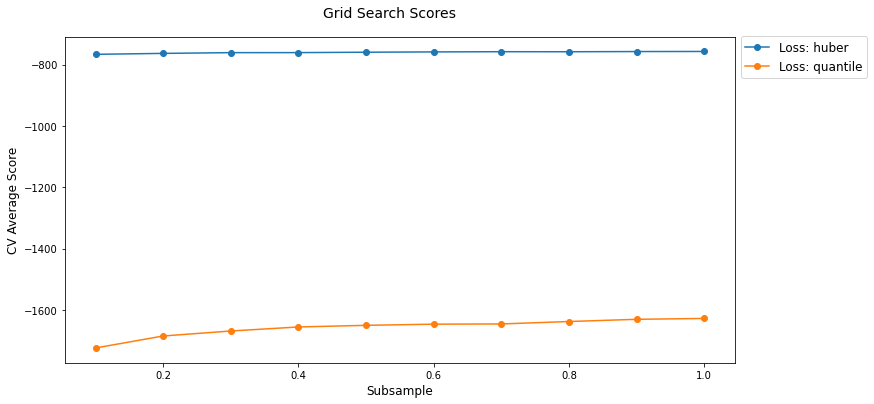

In [252]:
# Plot the results
plot_grid_search_results(GB_GS.cv_results_, 
                         GB_GS.param_grid['regressor__subsample'],
                         GB_GS.param_grid['regressor__loss'], 
                         'Subsample', 'Loss')

In [178]:
# def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
#     # Get Test Scores Mean and std for each grid search
#     scores_mean = cv_results['mean_test_score']
#     scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

#     scores_std = cv_results['std_test_score']
#     scores_std = np.array(scores_std).reshape(len(grid_param_2),len(grid_param_1))

#     # Plot Grid search scores
#     _, ax = plt.subplots(1,1, figsize=(8, 6))

#     # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
#     for idx, val in enumerate(grid_param_2):
#         ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
#         sns.lineplot(x=grid_param_1, y=scores_mean[idx,:])
#         ax.errorbar(grid_param_1, scores_mean[idx,:], yerr=scores_std[idx,:])

#     ax.set_title("Grid Search Scores", fontsize=14) 
#     ax.set_xlabel(name_param_1, fontsize=12) 
#     ax.set_ylabel('CV Average Score', fontsize=12) 
#     ax.legend(loc="best", fontsize=12, bbox_to_anchor=(1, 1))
# #     ax.grid('on')

In [72]:
# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('regressor', GradientBoostingRegressor(random_state=23))
                ])

# # Establish the parameter grid
# param_grid = { 'regressor__learning_rate': [0.001, 0.01, 0.1],
#                'regressor__loss': ['huber'],
#                'regressor__n_estimators': range(10, 110, 10),
#                'regressor__subsample': [0.8],
#                'regressor__max_depth': [5],
#                'regressor__min_samples_split': [40],
#                'regressor__min_samples_leaf': [20],
#                'regressor__max_features': ['sqrt'],
#               }
# Score with above search - 699.67

# # Establish the parameter grid
# param_grid = { 'regressor__learning_rate': [0.001],
#                'regressor__loss': ['huber'],
#                'regressor__n_estimators': [10, 100],
#                'regressor__subsample': [0.3, 0.5, 0.7, 0.9],
#                'regressor__max_depth': [3],
#                'regressor__min_samples_split': [2],
#                'regressor__min_samples_leaf': [1],
#                'regressor__max_features': ['sqrt'],
#               }
# Score with above search - 699.67

# # Establish the parameter grid
# param_grid = { 'regressor__learning_rate': [0.0001],
#                'regressor__loss': ['huber'],
#                'regressor__n_estimators': [10],
#                'regressor__subsample': [0.5],
#                'regressor__max_depth': [3],
#                'regressor__min_samples_split': [2],
#                'regressor__min_samples_leaf': [1],
#                'regressor__max_features': ['sqrt'],
#               }
# # Best Score (MAE): 699.35

# param_grid = { 'regressor__learning_rate': [0.0001],
#                'regressor__loss': ['huber'],
#                'regressor__n_estimators': [1],
#                'regressor__subsample': [0.5],
#                'regressor__max_depth': [3],
#                'regressor__min_samples_split': [2],
#                'regressor__min_samples_leaf': [1],
#                'regressor__max_features': ['auto']
#              }
# # Best Score (MAE): 699.32

# param_grid = { 'regressor__learning_rate': [0.0001],
#                'regressor__loss': ['huber'],
#                'regressor__n_estimators': [1, 10, 100, 1000],
#                'regressor__subsample': [0.5],
#                'regressor__max_depth': [3],
#                'regressor__min_samples_split': [2],
#                'regressor__min_samples_leaf': [1],
#                'regressor__max_features': ['auto']
#              }
# # Best Score (MAE): 699.32

# Instantiate the grid search and fit the model
GB_GS = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
GB_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=23))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.0001],
                         'regressor__loss': ['huber'],
                         'regressor__max_depth': [3],
                         'regressor__max_features': ['auto'],
                         'regressor__min_samples_leaf': [1],
                         'regressor__min_samples_split': [2],
                         'regressor

In [73]:
# Print best test score
best_score = -1 * round(np.max(GB_GS.cv_results_['mean_test_score']), 2)
print("Best Score (MAE): " + str(best_score))

Best Score (MAE): 699.32


In [74]:
# Print best params from grid search
print("Best Params:")
GB_GS.best_params_

Best Params:


{'regressor__learning_rate': 0.0001,
 'regressor__loss': 'huber',
 'regressor__max_depth': 3,
 'regressor__max_features': 'auto',
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 1,
 'regressor__subsample': 0.5}

Some rationale behind our initial set of parameters:
* **loss** - We'll go with 'huber' as a combination of squared error and absolute error
* **subsample** - For subsample, we'll start with a value less than one 

# Update text below
**Step 1** Tune learning rate vs. n_estimators
* Start with some basic parameter tuning
* Grid Search on n_estimators / learning rate
* Set other parameters and add rationale
* Plot result of score at different learning rate (line plot?) or scatter plot of learning rate and n_estimator combinations

**Step 2** Tune Tree-specific parameters
* https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
* Tune max_depth and num_samples_split
* Tune min_samples_leaf
* Tune max_features
The order of tuning variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we’re tuning those first.

Important Note: I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

To start with, I’ll test max_depth values of 5 to 15 in steps of 2 and min_samples_split from 200 to 1000 in steps of 200. These are just based on my intuition. You can set wider ranges as well and then perform multiple iterations for smaller ranges.

**Step 3** Tune sub-sample and loss functions

As a next step, let's tune our gradient boosting model by setting a few of the parameters and starting with a simple grid search of the n_estimators parameter to find an optimal number of trees for the default learning_rate of 0.1.

Though, GBM is robust enough to not overfit with increasing trees, but a high number for a particular learning rate can lead to overfitting. But as we reduce the learning rate and increase trees, the computation becomes expensive and would take a long time to run on standard personal computers.

Keeping all this in mind, we can take the following approach:

* Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
* Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
* Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
* Lower the learning rate and increase the estimators proportionally to get more robust models.




Next, we'll implement a grid search for the hyperparameter tuning, but in this case, we'll use a Random Grid Search. This will greatly reduce the number of possible hyperparameter combinations involved in the search, saving value compute time. And even though the search won't be exhaustive, there's a high likelihood we will find a set of hyperparamters resulting in a result that is *close to* the best we could get in a full grid search.

In [77]:
GB_regressor = GradientBoostingRegressor(learning_rate=0.0001, loss='huber', max_depth=3,
                                         max_features='auto', min_samples_leaf=1, min_samples_split=2,
                                         n_estimators=100, subsample=0.5)

pipe = make_pipeline(preprocessor, GB_regressor)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

-0.09092694071957963

In [78]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [79]:
mean_absolute_error(y_test, y_pred)

662.584805635588

### 4.2 Gradient Boosting with RandomizedSearchCV

In [26]:
# Create the random grid
random_grid = {'regressor__loss': ['huber'],
               'regressor__n_estimators': [100],
               'regressor__learning_rate': [0.1],
               'regressor__subsample': [0.8],
               'regressor__max_depth': [5],
               'regressor__min_samples_split': [40],
               'regressor__min_samples_leaf': [20],
               'regressor__max_features': ['sqrt'],
              }

# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('regressor', GradientBoostingRegressor(random_state=23, verbose=2))
                ])

# Instantiate the grid search and fit the model
GB_Random = RandomizedSearchCV(pipe, param_distributions=random_grid, scoring='neg_mean_absolute_error',
                               cv=5, n_jobs=-1)
GB_Random.fit(X_train, y_train)

/home/steve/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [          nan -758.21477713           nan -758.18367064 -759.09363999
           nan           nan           nan           nan           nan]
  warnings.warn(
/home/steve/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1630: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


      Iter       Train Loss      OOB Improve   Remaining Time 
         1      870878.3705       -2466.3164           18.34m
         2      832505.4062       32537.8237           28.39m
         3      806675.6930       25028.3591           26.47m
         4      780272.0340       23219.5855           27.68m
         5      771884.7116       17703.6998           31.07m
         6      752768.0400       15659.4907           31.38m
         7      745723.9102       12515.8487           31.02m
         8      713188.3129       11995.3577           33.43m
         9      717175.7810       11830.7957           35.13m
        10      697294.0745        9356.5469           35.28m
        11      686493.5315        9656.5113           35.20m
        12      687812.1911        6139.0666           34.82m
        13      684314.7053        5648.7096           34.18m
        14      696016.5215        3409.8821           33.85m
        15      672870.3913        3500.3985           33.30m
       

       133      651508.9805        -126.6187            4.13m
       134      632490.1270        -758.2568            3.88m
       135      649808.3917         -96.4204            3.64m
       136      644647.7507         -30.0873            3.40m
       137      647341.6924          13.5318            3.15m
       138      645753.5082         -66.5176            2.91m
       139      644174.4810         403.9140            2.66m
       140      651777.9566         -11.9328            2.42m
       141      636188.4951          22.8426            2.18m
       142      635455.3050         -76.9191            1.93m
       143      641971.8313          98.6564            1.69m
       144      643614.5052         -95.1711            1.45m
       145      646575.0813         -67.3768            1.21m
       146      640950.4685        -129.1873           57.95s
       147      654195.4431         -74.6286           43.56s
       148      637057.7958         -26.5983           29.04s
       1

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary'),
                                                                               ['Species'])])),
                                             ('regressor',
                                              GradientBoostingRegressor(random_state=23,
                                                                        verbose=2))]),
                   n_jobs=-1,
                   param_distributions={'regressor__criterion': ['mae'],
                                        'regressor__learning_rate': [0.05, 0.1,
                                                                     0.2],
                           

In [27]:
GB_Random.best_params_, GB_Random.best_score_

({'regressor__subsample': 0.8,
  'regressor__n_estimators': 150,
  'regressor__min_samples_split': 400,
  'regressor__min_samples_leaf': 50,
  'regressor__max_features': 'sqrt',
  'regressor__max_depth': 5,
  'regressor__loss': 'huber',
  'regressor__learning_rate': 0.1,
  'regressor__criterion': 'mae'},
 -758.1836706420484)

## 7 Huber Model
* good for data with outliers

In [272]:
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

# Make pipeline and get results
pipe = make_pipeline(preprocessor, StandardScaler(), HuberRegressor(epsilon=1.0, max_iter=200, alpha=0.01))
cv_results = cross_validate(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
score_mean = -1 * round(np.mean(cv_results['test_score']), 2)
print("mean test score (mae): " + str(score_mean))

mean test score (mae): 679.25


# Consider grid search on different Huber params and plot results

In [275]:
HB_regressor = HuberRegressor(epsilon=1.0, max_iter=200, alpha=0.01)

pipe = make_pipeline(preprocessor, HB_regressor)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

-0.014327109537764615

In [276]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [277]:
mean_absolute_error(y_test, y_pred)

648.0059596067262

## 8 Save Model

In [ ]:
# # Store some basic information about the model
# best_model = rf_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# # save the model

# modelpath = '../models'
# save_file(best_model, 'ski_resort_pricing_model.pkl', modelpath)